In [50]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, preprocessing, layers, applications, Model, optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU, concatenate


In [3]:
batch_size = 32
img_height = 224
img_width = 224

In [38]:
training_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/data/train",
    labels='inferred',
    label_mode='int',
    class_names= ['Accident', 'Non Accident'],
    color_mode='rgb',
    batch_size= batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=99,
)


Found 791 files belonging to 2 classes.


In [39]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/data/test",
    labels='inferred',
    label_mode='int',
    class_names= ['Accident', 'Non Accident'] ,
    color_mode='rgb',
    batch_size= batch_size ,
    image_size=(img_height, img_width),
    shuffle=False,
    seed=99,
)


Found 100 files belonging to 2 classes.


In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

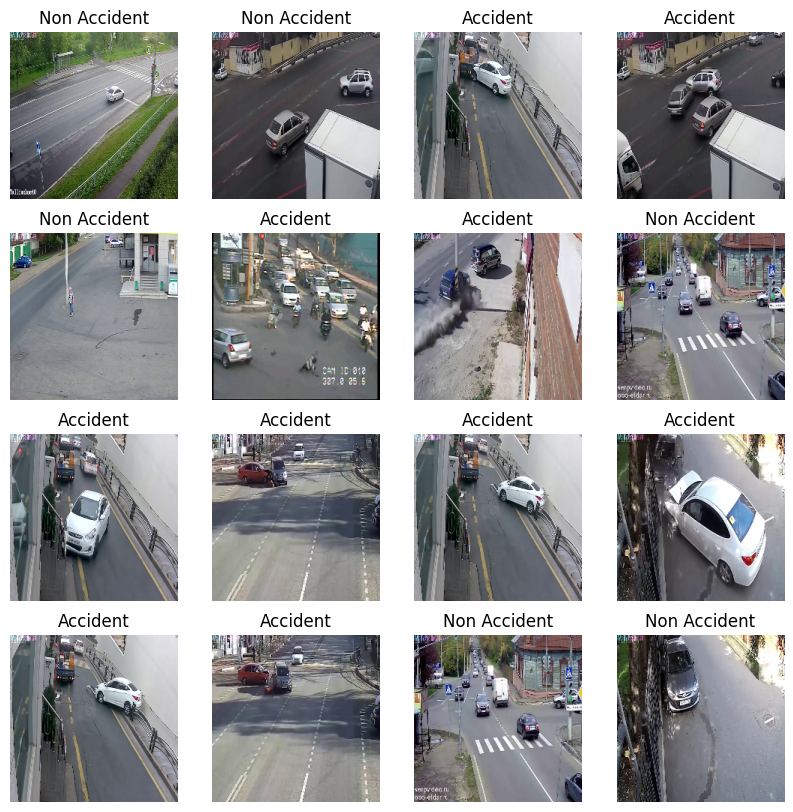

In [41]:
plt.figure(figsize=(10, 10))

for images, labels in training_ds.take(1):
    random_indices = np.random.choice(len(images), 16, replace=False)

    for i, idx in enumerate(random_indices):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[idx]/255.0)
        if labels[idx].shape == ():
            label_index = int(labels[idx])
        plt.title(['Accident', 'Non Accident'][label_index])
        plt.axis("off")


In [42]:
class SpinalNet(tf.keras.Model):
    def __init__(self, half_input, num_filters, num_classes):
        super(SpinalNet, self).__init__()

        self.half_input = half_input
        self.num_filters = num_filters
        self.num_classes = num_classes

        self.SpinalLayer1 = Sequential([
            Dropout(0.5),
            Dense(units=self.num_filters, input_shape=(self.half_input,)),
            BatchNormalization(),
            ReLU(),

        ])

        self.SpinalLayer2 = Sequential([
            Dropout(0.5),
            Dense(units=self.num_filters, input_shape=(self.half_input+self.num_filters,)),
            BatchNormalization(),
            ReLU(),
        ])

        self.SpinalLayer3 = Sequential([
            Dropout(0.5),
            Dense(units=self.num_filters, input_shape=(self.half_input+self.num_filters,)),
            BatchNormalization(),
            ReLU(),
        ])

        self.SpinalLayer4 = Sequential([
            Dropout(0.5),
            Dense(units=self.num_filters, input_shape=(self.half_input+self.num_filters,)),
            BatchNormalization(),
            ReLU(),
        ])

        self.Output = Sequential([
            Dropout(0.5),
            Dense(units=self.num_classes, input_shape=(self.num_filters*4,), activation ='softmax'),

        ])

    def call(self, x):
        x1 = self.SpinalLayer1(x[:, 0:self.half_input])
        x2 = self.SpinalLayer2(concatenate([x[:,self.half_input:2*self.half_input], x1], axis=1))
        x3 = self.SpinalLayer3(concatenate([ x[:,0:self.half_input], x2], axis=1))
        x4 = self.SpinalLayer4(concatenate([ x[:,self.half_input:2*self.half_input], x3], axis=1))

        x = concatenate([x1, x2])
        x = concatenate([x, x3])
        x = concatenate([x, x4])
        x = self.Output(x)

        return x


In [43]:
def ResNet50_Spinal(num_filters, num_classes):
    resnet = applications.ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    last_output = resnet.layers[-2].output
    num_features = resnet.layers[-1].input_shape[-1]
    half_input = round(num_features//2)
    num_filters = num_filters
    num_classes = num_classes
    spinalnet = SpinalNet(half_input = half_input, num_filters = 512, num_classes=num_classes)
    spinalnet.build(input_shape= (None, resnet.layers[-1].input_shape[-1]))
    input = Input(shape=last_output.shape[1:])
    x = spinalnet(last_output)
    resnet_model = keras.models.Model(inputs=resnet.input, outputs=x, name='ResNet50_Spinal')
    for layer in resnet.layers:
        layer.trainable = False
    return resnet_model



In [44]:
resnet_model = ResNet50_Spinal(num_filters = 20, num_classes = 2)

In [59]:
resnet_model.compile(optimizer= 'Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [60]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
def get_callbacks():
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    checkpoint = ModelCheckpoint('ads_SpinalNet.hdf5',verbose=1, save_best_only= True)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduce_lr, checkpoint, early_stop]

In [61]:
history = resnet_model.fit(training_ds,
                           validation_data= validation_ds,
                           epochs= 50,
                           batch_size=32,
                           callbacks=get_callbacks())

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.3641 - accuracy: 0.8571
Epoch 1: val_loss improved from inf to 0.33772, saving model to ads_SpinalNet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 11s 190ms/step - loss: 0.3641 - accuracy: 0.8571 - val_loss: 0.3377 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.8609
Epoch 2: val_loss improved from 0.33772 to 0.18263, saving model to ads_SpinalNet.hdf5
25/25 [==============================] - 3s 140ms/step - loss: 0.3065 - accuracy: 0.8609 - val_loss: 0.1826 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.3616 - accuracy: 0.8458
Epoch 3: val_loss improved from 0.18263 to 0.18079, saving model to ads_SpinalNet.hdf5
25/25 [==============================] - 4s 163ms/step - loss: 0.3616 - accuracy: 0.8458 - val_loss: 0.1808 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8609
Epoch 4: val_loss improved from 0.18079 to 0.17955, saving model to ads_SpinalNet.hdf5
25/25 [=================

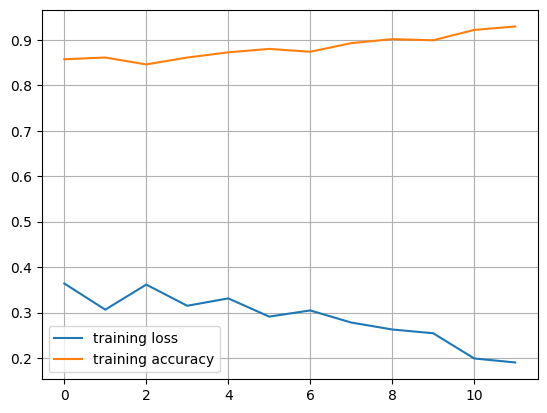

In [67]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

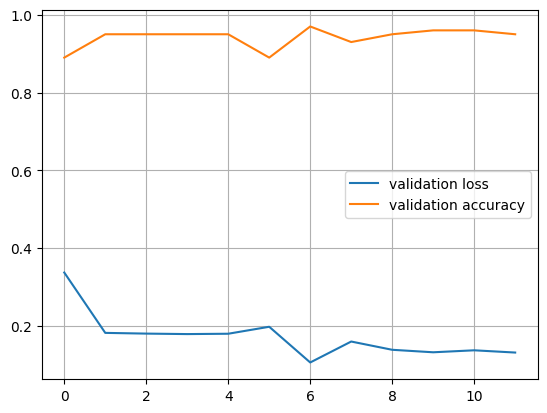

In [66]:
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [74]:
predictions = []
labels_list = []


for images, labels in testing_ds.take(4):
    preds = resnet_model.predict(images)
    pred_labels = np.argmax(preds, axis=-1)
    predictions.extend(pred_labels)
    labels_list.extend(labels.numpy())


predictions = np.array(predictions)
labels_list = np.array(labels_list)


1/1 [==============================] - 1s 1s/step


In [75]:

truePositive = 0
trueNegative = 0
falsePositive = 0
falseNegative = 0

for i in range(len(predictions)):
    pred_label = class_names[predictions[i]]
    true_label = class_names[labels_list[i]]

    if pred_label == 'Accident':
        if true_label == 'Accident':
            truePositive += 1
        else:
            falsePositive += 1
    else:
        if true_label == 'Non Accident':
            trueNegative += 1
        else:
            falseNegative += 1


print(f"True Positives: {truePositive}")
print(f"True Negatives: {trueNegative}")
print(f"False Positives: {falsePositive}")
print(f"False Negatives: {falseNegative}")


True Positives: 44
True Negatives: 53
False Positives: 0
False Negatives: 3


In [78]:
accuracy = (truePositive + trueNegative) / len(predictions)

precision = truePositive / (truePositive + falsePositive) if (truePositive + falsePositive) > 0 else 0

recall = truePositive / (truePositive + falseNegative) if (truePositive + falseNegative) > 0 else 0

f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


In [79]:
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1 Score: {f1_score:.5f}")

Accuracy: 0.97000
Precision: 1.00000
Recall: 0.93617
F1 Score: 0.96703
